### Libraries used



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd drive/MyDrive/NLP

/content/drive/MyDrive/NLP


In [4]:
ls

 AppReview-Multilabel.csv     'App Reviews-SingleLabel-Multiclass.csv'
'App Reviews-Multilabel.csv'   cc.ar.300.vec


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [6]:
# Set seed
SEED = 777

### Loading data

In [7]:
# Load dataset
df = pd.read_csv("AppReview-Multilabel.csv")
df.head()

,review,bug_report,improvement_request,rating,others
0,يبيله تصليحات كثير,High,Medium,Low,No
1,ماتحملت ابدددددا ونا دفعت فلوس 🤔😕,No,Medium,Medium,Low
2,اتمنى منكم عمل خيار لتفضيل المسلسل بالكامل عوض...,No,High,Low,No
3,ممتاز وبسيط وتشغيله لا يؤثر على سرعة الانترنت,No,No,High,No
4,تبين م لي ي تم ل يب,No,No,Low,High


In [8]:
print(df.describe())

              review bug_report improvement_request rating others
count           2900       2900                2900   2900   2900
unique          2892          4                   4      4      4
top     اكثر من رائع         No                  No   High     No
freq               3       1736                1797    988   2080


## Part-B: Multiclass App Review Classification: from scratch



#### B.1 Lable distribution

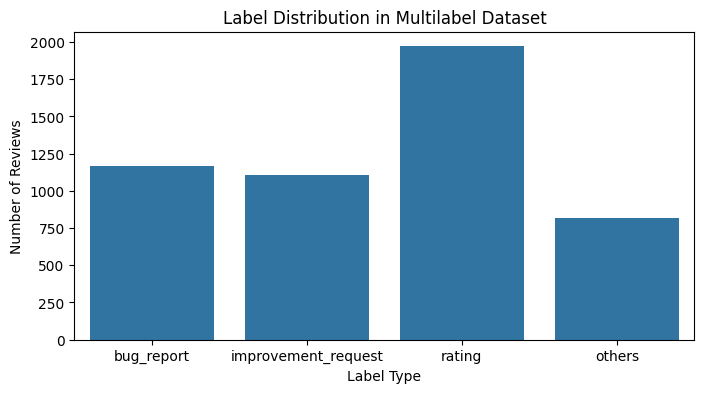

In [9]:
# Count non-"No" values to estimate multilabel counts
class_cols = ['bug_report', 'improvement_request', 'rating', 'others']
label_counts = {}

for col in class_cols:
    label_counts[col] = (df[col] != "No").sum()

# Plot label distribution
plt.figure(figsize=(8, 4))
sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()))
plt.title("Label Distribution in Multilabel Dataset")
plt.ylabel("Number of Reviews")
plt.xlabel("Label Type")
plt.show()


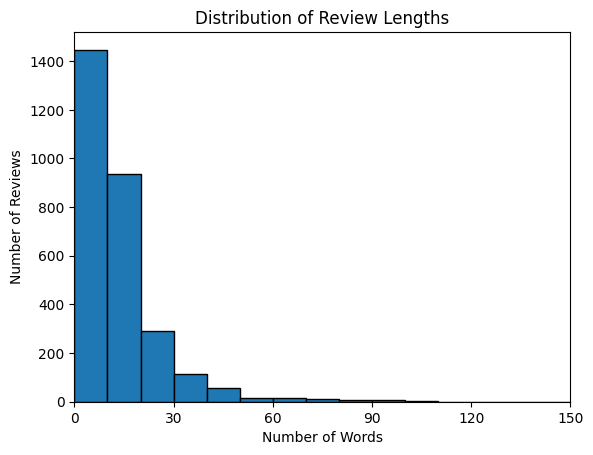


Average Review Length: 13.551724137931034


In [10]:
df['review_length'] = df['review'].apply(lambda x: len(str(x).split()))


plt.hist(df['review_length'], bins=range(0, 151, 10), edgecolor="black")  # Adjust bins for better granularity
plt.title("Distribution of Review Lengths")
plt.xlim(0, 150)  # Set x-axis range
plt.xticks(range(0, 151, 30))  # Adjust tick marks
plt.xlabel("Number of Words")
plt.ylabel("Number of Reviews")
plt.show()

print("\nAverage Review Length:", df['review_length'].mean())



#### B.2 Conversion to multiclass

In [11]:
def assign_single_label(row):
    if row['bug_report'] != 'No':
        return 'bug_report'
    elif row['improvement_request'] != 'No':
        return 'improvement_request'
    elif row['rating'] != 'No':
        return 'rating'
    else:
        return 'others'

df['label'] = df.apply(assign_single_label, axis=1)
df['label'].value_counts()


,count
label,
bug_report,1164
rating,944
improvement_request,595
others,197


#### B.3 Text preprocessing

In [12]:
def preprocess_arabic(text):
    text = str(text)
    # Normalize Arabic characters
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)

    # Remove diacritics
    text = re.sub(r'[\u064B-\u0652]', '', text)

    # Remove repeated characters
    text = re.sub(r'(.)\1+', r'\1\1', text) # kept 2 since some arabic words actually have two repeating letters

    # Remove non-Arabic letters and digits
    text = re.sub(r'[^\u0600-\u06FF\s]', '', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Apply preprocessing
df['cleaned_review'] = df['review'].apply(preprocess_arabic)
df[['review', 'cleaned_review']].head()

,review,cleaned_review
0,يبيله تصليحات كثير,يبيله تصليحات كثير
1,ماتحملت ابدددددا ونا دفعت فلوس 🤔😕,ماتحملت ابددا ونا دفعت فلوس
2,اتمنى منكم عمل خيار لتفضيل المسلسل بالكامل عوض...,اتمني منكم عمل خيار لتفضيل المسلسل بالكامل عوض...
3,ممتاز وبسيط وتشغيله لا يؤثر على سرعة الانترنت,ممتاز وبسيط وتشغيله لا يوثر علي سرعه الانترنت
4,تبين م لي ي تم ل يب,تبين م لي ي تم ل يب


#### B.4 Label encoding

In [13]:
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

# For reference
label_map = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_map)

Label Mapping: {'bug_report': np.int64(0), 'improvement_request': np.int64(1), 'others': np.int64(2), 'rating': np.int64(3)}


#### B.5 Data splitting

In [14]:
# First: Train-Test Split (80-20)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED, stratify=df['label_encoded'])

# Second: Validation Split from Train (15% of train)
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=SEED, stratify=train_df['label_encoded'])

# Show sizes
print(f"Training Samples: {len(train_df)}")
print(f"Validation Samples: {len(val_df)}")
print(f"Testing Samples: {len(test_df)}")

Training Samples: 1972
Validation Samples: 348
Testing Samples: 580


#### B.6 Tokeniation and padding

In [15]:
# Set parameters
MAX_NUM_WORDS = 10000  # top N words to keep
MAX_SEQUENCE_LENGTH = 120  # max words per review

# Tokenize
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['cleaned_review'])

# Convert to sequences
X_train_seq = tokenizer.texts_to_sequences(train_df['cleaned_review'])
X_val_seq = tokenizer.texts_to_sequences(val_df['cleaned_review'])
X_test_seq = tokenizer.texts_to_sequences(test_df['cleaned_review'])

# Pad sequences
X_train = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_val = pad_sequences(X_val_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_test = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [16]:
# One-hot encode labels
y_train = to_categorical(train_df['label_encoded'])
y_val = to_categorical(val_df['label_encoded'])
y_test = to_categorical(test_df['label_encoded'])

In [17]:
word_index = tokenizer.word_index
print(f"Vocabulary size: {len(word_index)}")

Vocabulary size: 8319


#### B.7 Building LSTM model

##### B.7.1 LSTM with random embedding

In [ ]:
# Parameters
EMBEDDING_DIM_RANDOM = 100  # can be smaller
NUM_CLASSES = y_train.shape[1]

model_random = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS,
              output_dim=EMBEDDING_DIM_RANDOM,
              input_length=MAX_SEQUENCE_LENGTH,
              trainable=True),  # learn embeddings during training
    LSTM(128),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(NUM_CLASSES, activation='softmax')
])

model_random.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_random.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

##### B.7.2 LSTM with pretrained embedding

In [ ]:
# Load pretrained FastText embeddings
embedding_index = {}
with open("cc.ar.300.vec", encoding='utf-8') as f:
    next(f)  # skip header
    for line in f:
        values = line.rstrip().split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

print(f"Loaded {len(embedding_index)} word vectors.")

# Build embedding matrix
EMBEDDING_DIM_PRETRAINED = 300
embedding_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM_PRETRAINED))

for word, i in tokenizer.word_index.items():
    if i < MAX_NUM_WORDS:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Model 2: Use precomputed FastText vectors
model_pretrained = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS,
              output_dim=EMBEDDING_DIM_PRETRAINED,
              weights=[embedding_matrix],
              input_length=MAX_SEQUENCE_LENGTH,
              trainable=False),  # freeze embeddings
    LSTM(128),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(NUM_CLASSES, activation='softmax')
])

model_pretrained.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_pretrained.summary()


Loaded 2000000 word vectors.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,000,000 (11.44 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,000,000 (11.44 MB)

#### B.8 Model training

In [18]:
EPOCHS = 20
BATCH_SIZE = 32

In [ ]:
# Train model 1
print("Training Model with Random Embeddings...\n")
history_random = model_random.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Training Model with Random Embeddings...

Epoch 1/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 18s 234ms/step - accuracy: 0.3601 - loss: 1.2892 - val_accuracy: 0.4023 - val_loss: 1.2405
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 15s 241ms/step - accuracy: 0.3741 - loss: 1.2683 - val_accuracy: 0.4023 - val_loss: 1.2419
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 14s 229ms/step - accuracy: 0.4084 - loss: 1.2527 - val_accuracy: 0.4023 - val_loss: 1.2417
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 14s 230ms/step - accuracy: 0.3956 - loss: 1.2483 - val_accuracy: 0.4023 - val_loss: 1.2411
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 16s 256ms/step - accuracy: 0.4065 - loss: 1.2240 - val_accuracy: 0.4023 - val_loss: 1.2499
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 239ms/step - accuracy: 0.4161 - loss: 1.2510 - val_accuracy: 0.3247 - val_loss: 1.2454
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 14s 224ms/step - accuracy: 0.3681 - loss: 1.2501 - val_accuracy: 0.4023 - val_loss: 1.2404
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 240ms/step - 

In [ ]:
# Train model 2
print("Training Model with Pretrained FastText Embeddings...\n")
history_pretrained = model_pretrained.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)


Training Model with Pretrained FastText Embeddings...

Epoch 1/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 19s 256ms/step - accuracy: 0.3766 - loss: 1.3376 - val_accuracy: 0.4023 - val_loss: 1.2493
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 245ms/step - accuracy: 0.3943 - loss: 1.2493 - val_accuracy: 0.4023 - val_loss: 1.2464
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 247ms/step - accuracy: 0.3401 - loss: 1.2627 - val_accuracy: 0.4023 - val_loss: 1.2439
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 23s 284ms/step - accuracy: 0.3887 - loss: 1.2501 - val_accuracy: 0.4023 - val_loss: 1.2411
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 18s 250ms/step - accuracy: 0.3904 - loss: 1.2461 - val_accuracy: 0.4023 - val_loss: 1.2434
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 249ms/step - accuracy: 0.3854 - loss: 1.2619 - val_accuracy: 0.4023 - val_loss: 1.2416
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 15s 250ms/step - accuracy: 0.3957 - loss: 1.2357 - val_accuracy: 0.4023 - val_loss: 1.2417
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 

In [ ]:
loss_random, accuracy_random = model_random.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (Random Embeddings): {loss_random:.4f}")
print(f"Test Accuracy (Random Embeddings): {accuracy_random:.4f}")

Test Loss (Random Embeddings): 1.2390
Test Accuracy (Random Embeddings): 0.4017


In [ ]:
loss_pretrained, accuracy_pretrained = model_pretrained.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (Pretrained Embeddings): {loss_pretrained:.4f}")
print(f"Test Accuracy (Pretrained Embeddings): {accuracy_pretrained:.4f}")

Test Loss (Pretrained Embeddings): 1.2383
Test Accuracy (Pretrained Embeddings): 0.4017


#### B.9 Classification analysis and possible improvements.

##### B.9.1 Applying oversampling

In [ ]:
# Combine features and labels
train_df_combined = train_df[['cleaned_review', 'label_encoded']]

# Separate by class
classes = train_df_combined['label_encoded'].unique()
class_dfs = [train_df_combined[train_df_combined['label_encoded'] == c] for c in classes]

# Find the class with max samples
max_len = max([len(df) for df in class_dfs])

# Oversample minority classes
resampled_dfs = [
    resample(df, replace=True, n_samples=max_len, random_state=SEED)
    if len(df) < max_len else df
    for df in class_dfs
]

# Concatenate back
balanced_train_df = pd.concat(resampled_dfs).sample(frac=1, random_state=SEED)  # shuffle

print("Balanced class counts:")
print(balanced_train_df['label_encoded'].value_counts())

Balanced class counts:
label_encoded
2    791
1    791
3    791
0    791
Name: count, dtype: int64


In [ ]:
# Tokenize balanced data
X_train_balanced_seq = tokenizer.texts_to_sequences(balanced_train_df['cleaned_review'])
X_train_balanced = pad_sequences(X_train_balanced_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

# Labels
y_train_balanced = to_categorical(balanced_train_df['label_encoded'])

##### B.9.2 Modifying the model to use (Oversampled data, BiLSTM, Callback functions)

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]

In [ ]:
EMBEDDING_DIM_RANDOM = 100
NUM_CLASSES = y_train.shape[1]

model_os_random = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS,
              output_dim=EMBEDDING_DIM_RANDOM,
              input_length=MAX_SEQUENCE_LENGTH,
              trainable=True),
    Bidirectional(LSTM(128)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(NUM_CLASSES, activation='softmax')
])

model_os_random.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_os_random.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
EMBEDDING_DIM_PRETRAINED = 300

model_os_pretrained = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS,
              output_dim=EMBEDDING_DIM_PRETRAINED,
              weights=[embedding_matrix],
              input_length=MAX_SEQUENCE_LENGTH,
              trainable=False),
    Bidirectional(LSTM(128)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(NUM_CLASSES, activation='softmax')
])

model_os_pretrained.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_os_pretrained.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,000,000 (11.44 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,000,000 (11.44 MB)

In [ ]:
EPOCHS = 7
BATCH_SIZE = 32

In [ ]:
# Train model with Random Embeddings
print("Training BiLSTM with Random Embeddings...\n")
history_os_random = model_os_random.fit(
    X_train_balanced, y_train_balanced,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)

Training BiLSTM with Random Embeddings...

Epoch 1/7
99/99 ━━━━━━━━━━━━━━━━━━━━ 49s 434ms/step - accuracy: 0.3252 - loss: 1.3517 - val_accuracy: 0.5805 - val_loss: 1.0194 - learning_rate: 0.0010
Epoch 2/7
99/99 ━━━━━━━━━━━━━━━━━━━━ 43s 437ms/step - accuracy: 0.8412 - loss: 0.4815 - val_accuracy: 0.6207 - val_loss: 1.0492 - learning_rate: 0.0010
Epoch 3/7
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.9779 - loss: 0.1042
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
99/99 ━━━━━━━━━━━━━━━━━━━━ 41s 419ms/step - accuracy: 0.9778 - loss: 0.1042 - val_accuracy: 0.6466 - val_loss: 1.3577 - learning_rate: 0.0010
Epoch 4/7
99/99 ━━━━━━━━━━━━━━━━━━━━ 42s 421ms/step - accuracy: 0.9947 - loss: 0.0285 - val_accuracy: 0.6437 - val_loss: 1.5692 - learning_rate: 5.0000e-04
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


In [ ]:
# Evaluate the model with random embeddings on the test data
loss_os_random, accuracy_os_random = model_os_random.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (Random Embeddings): {loss_os_random:.4f}")
print(f"Test Accuracy (Random Embeddings): {accuracy_os_random:.4f}")


Test Loss (Random Embeddings): 0.9473
Test Accuracy (Random Embeddings): 0.6259


In [ ]:
# Train model with Pretrained FastText Embeddings
print("Training BiLSTM with Pretrained FastText Embeddings...\n")
history_os_pretrained = model_os_pretrained.fit(
    X_train_balanced, y_train_balanced,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)

Training BiLSTM with Pretrained FastText Embeddings...

Epoch 1/7
99/99 ━━━━━━━━━━━━━━━━━━━━ 51s 454ms/step - accuracy: 0.4004 - loss: 1.3054 - val_accuracy: 0.6063 - val_loss: 1.0299 - learning_rate: 0.0010
Epoch 2/7
99/99 ━━━━━━━━━━━━━━━━━━━━ 53s 532ms/step - accuracy: 0.6387 - loss: 0.9185 - val_accuracy: 0.6293 - val_loss: 0.8710 - learning_rate: 0.0010
Epoch 3/7
99/99 ━━━━━━━━━━━━━━━━━━━━ 50s 504ms/step - accuracy: 0.7161 - loss: 0.7364 - val_accuracy: 0.6552 - val_loss: 0.8225 - learning_rate: 0.0010
Epoch 4/7
99/99 ━━━━━━━━━━━━━━━━━━━━ 76s 445ms/step - accuracy: 0.7759 - loss: 0.6002 - val_accuracy: 0.6609 - val_loss: 0.8461 - learning_rate: 0.0010
Epoch 5/7
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.8195 - loss: 0.5020
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
99/99 ━━━━━━━━━━━━━━━━━━━━ 85s 474ms/step - accuracy: 0.8195 - loss: 0.5021 - val_accuracy: 0.6638 - val_loss: 0.8686 - learning_rate: 0.0010
Epoch 6/7
99/99 ━━━━━━━━━━━━━━━━━

In [ ]:
# Evaluate the model with pretrained embeddings on the test data
loss_os_pretrained, accuracy_os_pretrained = model_os_pretrained.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (Pretrained Embeddings): {loss_os_pretrained:.4f}")
print(f"Test Accuracy (Pretrained Embeddings): {accuracy_os_pretrained:.4f}")

Test Loss (Pretrained Embeddings): 0.8412
Test Accuracy (Pretrained Embeddings): 0.6534


## Part-C: Multilabel App Review Classification: from scratch

### C.1 Loading data

In [19]:
# Load multilabel dataset
df = pd.read_csv("App Reviews-Multilabel.csv")

# Define label columns
label_cols = ['bug_report', 'improvement_request', 'rating', 'others']

#### C.2 Data statistics

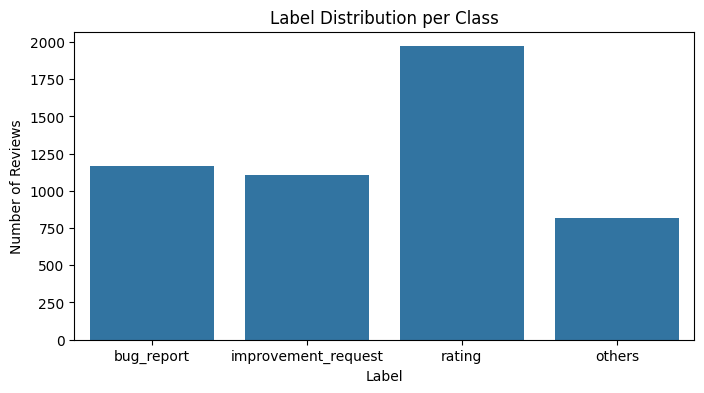


 bug_report             1164
improvement_request    1103
rating                 1971
others                  820
dtype: int64


In [22]:
label_sums = df[label_cols].sum()

plt.figure(figsize=(8, 4))
sns.barplot(x=label_sums.index, y=label_sums.values)
plt.title("Label Distribution per Class")
plt.ylabel("Number of Reviews")
plt.xlabel("Label")
plt.show()

print("\n",label_sums)


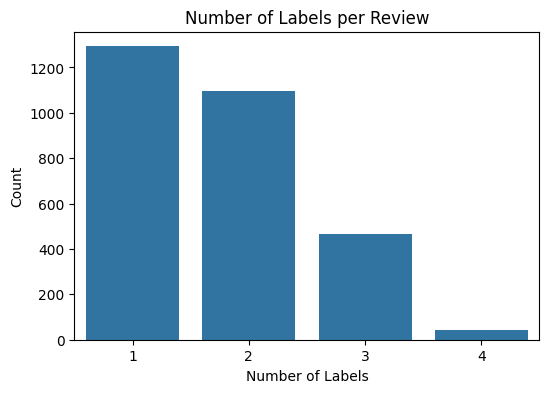

num_labels
1    1293
2    1098
3     467
4      42
Name: count, dtype: int64


In [23]:
df['num_labels'] = df[label_cols].sum(axis=1)

plt.figure(figsize=(6, 4))
sns.countplot(x=df['num_labels'])
plt.title("Number of Labels per Review")
plt.xlabel("Number of Labels")
plt.ylabel("Count")
plt.show()

print(df['num_labels'].value_counts().sort_index())


Average review length: 13.346206896551724
Max review length: 576


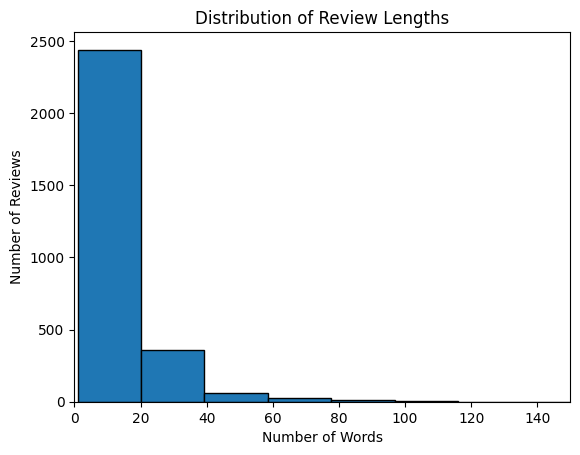

In [24]:
df['review_length'] = df['cleaned_review'].apply(lambda x: len(x.split()))

print("Average review length:", df['review_length'].mean())
print("Max review length:", df['review_length'].max())

plt.hist(df['review_length'], bins=30, edgecolor='black')
plt.title("Distribution of Review Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Number of Reviews")
plt.xlim(0, 150)
plt.show()


#### C.3 Text preprocessing

In [20]:
def preprocess_arabic(text):
    text = str(text)
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    text = re.sub(r'[\u064B-\u0652]', '', text)
    text = re.sub(r'(.)\1+', r'\1\1', text)
    text = re.sub(r'[^\u0600-\u06FF\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['cleaned_review'] = df['review'].apply(preprocess_arabic)
df.head()

,review,bug_report,improvement_request,rating,others,cleaned_review
0,يبيله تصليحات كثير,1,1,1,0,يبيله تصليحات كثير
1,ماتحملت ابدددددا ونا دفعت فلوس 🤔😕,0,1,1,1,ماتحملت ابددا ونا دفعت فلوس
2,اتمنى منكم عمل خيار لتفضيل المسلسل بالكامل عوض...,0,1,1,0,اتمني منكم عمل خيار لتفضيل المسلسل بالكامل عوض...
3,ممتاز وبسيط وتشغيله لا يؤثر على سرعة الانترنت,0,0,1,0,ممتاز وبسيط وتشغيله لا يوثر علي سرعه الانترنت
4,تبين م لي ي تم ل يب,0,0,1,1,تبين م لي ي تم ل يب


#### C.4 Data splitting

In [27]:
label_cols = ['bug_report', 'improvement_request', 'rating', 'others']
X_text = df['cleaned_review']
y = df[label_cols].values

# 80-20 train/test
X_train_text, X_test_text, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=SEED)

# 15% val from train
X_train_text, X_val_text, y_train, y_val = train_test_split(X_train_text, y_train, test_size=0.15, random_state=SEED)


#### C.5 Tokenization and padding

In [28]:
MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 120

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_text)

X_train = pad_sequences(tokenizer.texts_to_sequences(X_train_text), maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_val = pad_sequences(tokenizer.texts_to_sequences(X_val_text), maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test_text), maxlen=MAX_SEQUENCE_LENGTH, padding='post')

#### C.6 Building BiLSTM model

In [29]:
embedding_index = {}
with open("cc.ar.300.vec", encoding='utf-8') as f:
    next(f)  # skip header
    for line in f:
        values = line.rstrip().split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

print(f"Loaded {len(embedding_index)} word vectors.")

Loaded 2000000 word vectors.


In [30]:
# Build embedding matrix
EMBEDDING_DIM = 300
embedding_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM))

for word, i in tokenizer.word_index.items():
    if i < MAX_NUM_WORDS:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [31]:
np.save('embedding_matrix.npy', embedding_matrix)


In [32]:
NUM_CLASSES = len(label_cols)

model = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS,
              output_dim=EMBEDDING_DIM,
              weights=[embedding_matrix],
              input_length=MAX_SEQUENCE_LENGTH,
              trainable=False),
    Bidirectional(LSTM(128, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(NUM_CLASSES, activation='sigmoid')  # multilabel output
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,000,000 (11.44 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,000,000 (11.44 MB)

In [33]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

EPOCHS = 20
BATCH_SIZE = 32

In [34]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)

Epoch 1/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 37s 485ms/step - accuracy: 0.3415 - loss: 0.6499 - val_accuracy: 0.5316 - val_loss: 0.5929 - learning_rate: 0.0010
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 37s 430ms/step - accuracy: 0.4719 - loss: 0.5718 - val_accuracy: 0.4626 - val_loss: 0.5277 - learning_rate: 0.0010
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 40s 409ms/step - accuracy: 0.5648 - loss: 0.4970 - val_accuracy: 0.5172 - val_loss: 0.4993 - learning_rate: 0.0010
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 42s 420ms/step - accuracy: 0.5869 - loss: 0.4458 - val_accuracy: 0.5345 - val_loss: 0.4813 - learning_rate: 0.0010
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 31s 499ms/step - accuracy: 0.5806 - loss: 0.4500 - val_accuracy: 0.5948 - val_loss: 0.4643 - learning_rate: 0.0010
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 405ms/step - accuracy: 0.6190 - loss: 0.4140 - val_accuracy: 0.5489 - val_loss: 0.4798 - learning_rate: 0.0010
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 42s 422ms/step - accuracy: 0.6396 - loss: 0.

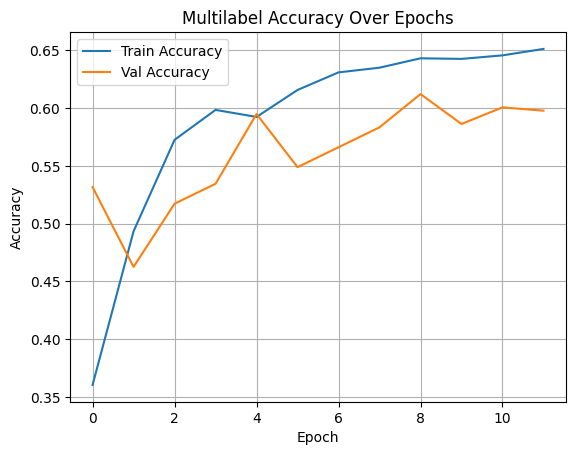

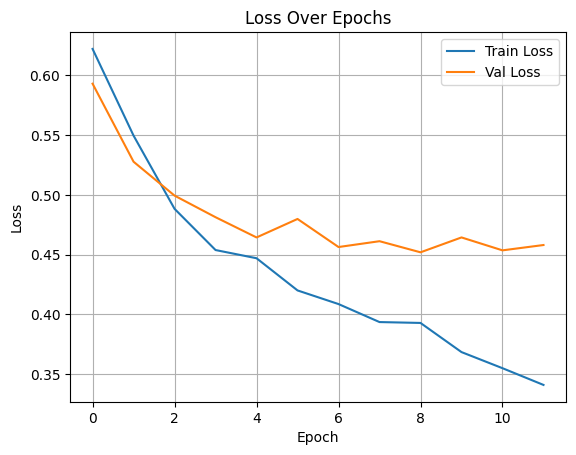

In [38]:
# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Multilabel Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

#### C.7 Model evaluation

In [37]:
y_pred_probs = model.predict(X_test)
y_pred_binary = (y_pred_probs >= 0.5).astype(int)  # thresholding

print("Multilabel Classification Report:\n")
print(classification_report(y_test, y_pred_binary, target_names=label_cols, zero_division=0))

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step
Multilabel Classification Report:

                     precision    recall  f1-score   support

         bug_report       0.76      0.77      0.77       239
improvement_request       0.69      0.66      0.67       238
             rating       0.86      0.83      0.85       384
             others       0.75      0.38      0.51       159

          micro avg       0.78      0.71      0.74      1020
          macro avg       0.77      0.66      0.70      1020
       weighted avg       0.78      0.71      0.74      1020
        samples avg       0.82      0.76      0.75      1020



## Part-D: Multiclass App Review Classification: Finetune an MLM

## Part-E: Multilabel App Review Classification: Finetune an MLM

## Part-F: Multiclass App Review Classification: In-Context learning using causal LLM


#### Zero-shot learning

#### Few-shot learning

## Part-G: Multilabel App Review Classification: In-Context learning using causal LLM


#### Zero-shot learning

#### Few-shot learning